# Pneuomonia Recognition

Il nostro obiettivo è riuscire a classificare immagini di radiografie del torace in base alla presenza o assenza di polmonite.
Per eseguire questo task proveremo due diversi classificatori:
* Alberi decisionali con l'uso di Random Forest
* Convolutional Neural Networks

In [1]:
import numpy as np
X = np.load("pneumonia_images.npy")
y = np.load("pneumonia_labels.npy")

Visualizziamo alcune immagini del dataset, target pari ad uno indicano un caso di Polmonite, 0 indica assenza di Polmonite

In [2]:
print("Number of images:", X.shape[0])
positive = 0
negative = 0

for i in range(X.shape[0]):
    if(y[i]==1):
        positive += 1
    if(y[i]==0):
        negative += 1

print("Number of positive cases:", positive)
print("Number of negative cases:", negative)

Number of images: 5232
Number of positive cases: 3883
Number of negative cases: 1349


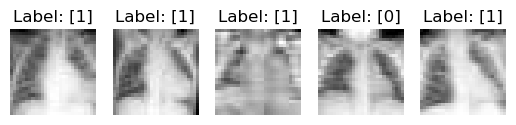

In [3]:
import matplotlib.pyplot as plt


# Visualizza alcune immagini
num_images_to_display = 5

for i in range(num_images_to_display):
    # Seleziona un'immagine casuale
    index = np.random.randint(0, len(X))
    image = X[index]
    label = y[index]

    # Visualizza l'immagine con la sua etichetta
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.show()

Il dataset è sbilanciato verso le immagini con polmonite:

Circa il 74.2% delle immagini rappresentano casi di polmonite.
Circa il 25.8% delle immagini rappresentano casi negativi.

Andiamo a suddividere il train set tra training e test, utilizzando stratify per mantenere proporzione tra le classi

In [4]:
from sklearn.model_selection import train_test_split

# Suddivisione in set di addestramento e set di validazione
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

A questo punto andiamo a dividere il Training Set in Training e Validation, mantenendo la stessa proporzione

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [6]:
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_val_reshaped = X_valid.reshape(X_valid.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

In [7]:
import numpy as np

print("Valore minimo dei pixel:", np.min(X_train_reshaped))
print("Valore massimo dei pixel:", np.max(X_train_reshaped))

Valore minimo dei pixel: 0
Valore massimo dei pixel: 255


Vado a normalizzare i dati dopo aver suddiviso Training, Validation e Test per evitare Data Leakage.
Essendo immagini in scala di grigi, possiamo semplicemente dividere il valore dei pixel per 255.

In [8]:
# Normalizzazione delle immagini in scala di grigi
X_train_normalized = X_train / 255.0
X_val_normalized = X_valid / 255.0
X_test_normalized = X_test / 255.0

In [9]:
import numpy as np

print("Valore minimo dei pixel:", np.min(X_train_normalized))
print("Valore massimo dei pixel:", np.max(X_train_normalized))

Valore minimo dei pixel: 0.0
Valore massimo dei pixel: 1.0


In [10]:
print(f'Original X_train shape: {X_train.shape}')
print(f'Normalized X_train shape: {X_train_normalized.shape}')

print(f'Original X_val shape: {X_valid.shape}')
print(f'Normalized X_val shape: {X_val_normalized.shape}')

print(f'Original X_test shape: {X_test.shape}')
print(f'Normalized X_test shape: {X_test_normalized.shape}')

Original X_train shape: (3348, 28, 28)
Normalized X_train shape: (3348, 28, 28)
Original X_val shape: (837, 28, 28)
Normalized X_val shape: (837, 28, 28)
Original X_test shape: (1047, 28, 28)
Normalized X_test shape: (1047, 28, 28)


## Alberi decisionali

Cominciamo con un semplice Albero Decisionale, vado quindi ad appiattire i miei dati e usiamo Ravel sui target per trasformarli in vettori 1D

In [32]:
X_train_flatten = X_train_normalized.reshape(X_train_normalized.shape[0], -1)
X_val_flatten = X_val_normalized.reshape(X_val_normalized.shape[0], -1)
X_test_flatten = X_test_normalized.reshape(X_test_normalized.shape[0], -1)
y_train_ravel = y_train.ravel()
y_valid_ravel = y_valid.ravel()
y_test_ravel = y_test.ravel()
print(f"Flattened training set size: {X_train_flatten.shape}")
print(f"Flattened validation set size: {X_val_flatten.shape}")
print(f"Flattened test set size: {X_test_flatten.shape}")
print(f"Train set label size: {y_train.shape}")
print(f"Validation set label size: {y_valid.shape}")
print(f"Test set label size: {y_test.shape}")

Flattened training set size: (3348, 784)
Flattened validation set size: (837, 784)
Flattened test set size: (1047, 784)
Train set label size: (3348, 1)
Validation set label size: (837, 1)
Test set label size: (1047, 1)


Visto il numero esiguo di dati, usiamo per testare il modello Cross-Validation, utilizzando la Cross-Validation, è possibile ottenere stime più realistiche delle prestazioni del modello su dati non visti.

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score

Scores della cross-validation (F1): [0.94608342 0.93253968 0.92292292 0.93711968 0.93293293]
Media della cross-validation (F1): 0.93 (+/- 0.01)
F1-score sul set di validazione: 0.93
F1-score sul set di test: 0.93

Matrice di Confusione sul set di test:


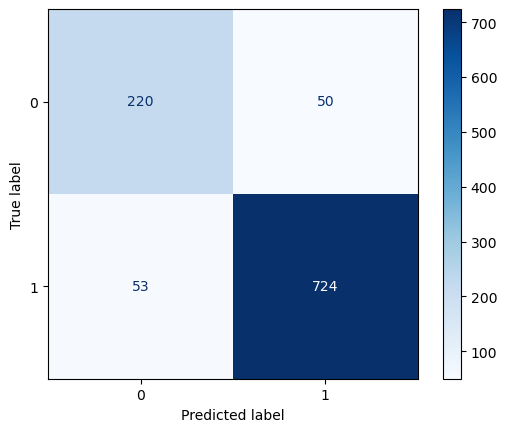

In [40]:
clf = DecisionTreeClassifier()
cv_scores = cross_val_score(clf, X_train_flatten, y_train_ravel, cv=5, scoring='f1')

# Stampare i punteggi ottenuti dalla cross-validation
print("Scores della cross-validation (F1):", cv_scores)
print(f"Media della cross-validation (F1): {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")

# Passo 3: Addestra il modello sul set di addestramento completo
clf.fit(X_train_flatten, y_train_ravel)

# Passo 4: Valida il modello sul set di validazione
y_val_pred = clf.predict(X_val_flatten)
val_f1 = f1_score(y_valid_ravel, y_val_pred)
print(f"F1-score sul set di validazione: {val_f1:.2f}")

# Passo 5: Valuta definitivamente il modello sul set di test
y_test_pred = clf.predict(X_test_flatten)
test_conf_matrix = confusion_matrix(y_test_ravel, y_test_pred)
test_f1 = f1_score(y_test_ravel, y_test_pred)
print(f"F1-score sul set di test: {test_f1:.2f}")
print("\nMatrice di Confusione sul set di test:")
disp = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()


### Random Forest

Per migliorare l'accuratezza del modello, proviamo l'uso di Random Forest, applichiamo quindi la tecnica del Bagging sugli alberi decisionali.

Scores della cross-validation (F1): [0.97079557 0.968      0.95575221 0.9740519  0.96729435]
Media della cross-validation (F1): 0.97 (+/- 0.01)
F1-score sul set di validazione: 0.96
F1-score sul set di test: 0.96

Matrice di Confusione sul set di test:


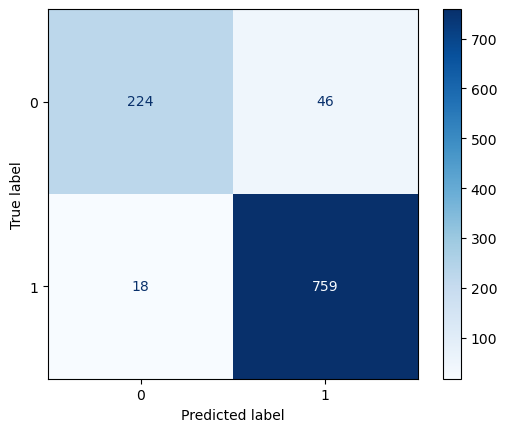

In [41]:
from sklearn.ensemble import RandomForestClassifier

randomFC = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores = cross_val_score(randomFC, X_train_flatten, y_train_ravel, cv=5, scoring='f1')

# Stampare i punteggi ottenuti dalla cross-validation
print("Scores della cross-validation (F1):", cv_scores)
print(f"Media della cross-validation (F1): {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")

# Passo 3: Addestra il modello sul set di addestramento completo
randomFC.fit(X_train_flatten, y_train_ravel)

# Passo 4: Valida il modello sul set di validazione
y_val_pred = randomFC.predict(X_val_flatten)
val_f1 = f1_score(y_valid_ravel, y_val_pred)
print(f"F1-score sul set di validazione: {val_f1:.2f}")

# Passo 5: Valuta definitivamente il modello sul set di test
y_test_pred = randomFC.predict(X_test_flatten)
test_conf_matrix = confusion_matrix(y_test_ravel, y_test_pred)
test_f1 = f1_score(y_test_ravel, y_test_pred)
print(f"F1-score sul set di test: {test_f1:.2f}")
print("\nMatrice di Confusione sul set di test:")
disp = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### RandomizedSearchCV

Usare GridSearch per trovare i migliori parametri su Random Forest richiederebbe una quantità di tempo troppo elevata, usiamo quindi RandomizedSearchCV che va a campionare un numero fissato di impostazioni dei parametri da una distribuzione di probabilità piuttosto che cercare ogni combinazione possibile.

In [27]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

randomFCRSRS = RandomForestClassifier(random_state=42)

param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20)
}

random_search = RandomizedSearchCV(estimator=randomFCRSRS, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train_flatten, y_train_ravel)

print(f"Best parameters found: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters found: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 11, 'n_estimators': 656}
Best cross-validation score: 0.9498230818999174


Creiamo il modello con i parametri trovati tramite la RandomizedSearchCV

Scores della cross-validation (F1): [0.97079557 0.96510469 0.95874263 0.97512438 0.96347483]
Media della cross-validation (F1): 0.97 (+/- 0.01)
F1-score sul set di validazione: 0.96
F1-score sul set di test: 0.96

Matrice di Confusione sul set di test:


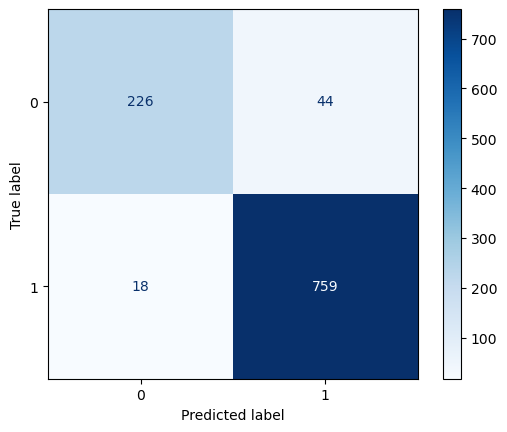

In [43]:
from sklearn.ensemble import RandomForestClassifier

# Migliori parametri ottenuti dalla ricerca
best_params = {
    'max_depth': 20,
    'max_features': 'sqrt',
    'min_samples_leaf': 2,
    'min_samples_split': 11,
    'n_estimators': 656,
    'random_state': 42
}

# Creare un nuovo modello con i parametri ottimali
best_model = RandomForestClassifier(**best_params)

cv_scores = cross_val_score(best_model, X_train_flatten, y_train_ravel, cv=5, scoring='f1')

# Stampare i punteggi ottenuti dalla cross-validation
print("Scores della cross-validation (F1):", cv_scores)
print(f"Media della cross-validation (F1): {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")

# Passo 3: Addestra il modello sul set di addestramento completo
best_model.fit(X_train_flatten, y_train_ravel)

# Passo 4: Valida il modello sul set di validazione
y_val_pred = best_model.predict(X_val_flatten)
val_f1 = f1_score(y_valid_ravel, y_val_pred)
print(f"F1-score sul set di validazione: {val_f1:.2f}")

# Passo 5: Valuta definitivamente il modello sul set di test
y_test_pred = best_model.predict(X_test_flatten)
test_conf_matrix = confusion_matrix(y_test_ravel, y_test_pred)
test_f1 = f1_score(y_test_ravel, y_test_pred)
print(f"F1-score sul set di test: {test_f1:.2f}")
print("\nMatrice di Confusione sul set di test:")
disp = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Convolutional Neural Networks

Andiamo a eseguire il Training tramite Convolutional Neural Networks, utilizziamo una semplice CNN composta da 2 strati convoluzionali e uno strato Dense da 128 unità per la classificazione binaria, quest'ultima realizzata con un livello Dense di 1 unità con funzione di attivazione sigmoid.

Inanzitutto, vista la diversa gestione delle metriche di tensorflow rispetto a scikit-learn, implementiamo una metrica F1-Score personalizzata:
Calcoliamo quindi separatamente, la recall e la precision, e implementiamo la F1 come: $$ F1 = 2 \cdot \frac{precision \cdot recall}{precision + recall} $$


In [11]:
from tensorflow.keras import backend as K

# Funzione per calcolare l'F1-score
def f1_score_personalized(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision_value = precision(y_true, y_pred)
    recall_value = recall(y_true, y_pred)
    f1 = 2 * ((precision_value * recall_value) / (precision_value + recall_value + K.epsilon()))
    return f1

Ora definiamo una funzione per la stampa dei vari grafici, necessari durante il Training

In [12]:
import matplotlib.pyplot as plt

def graphics(history):
    plt.figure(figsize=(12, 4))

    # Plot della perdita
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot delle metriche
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['f1_score_personalized'], label='Training F1 Score')
    plt.plot(history.history['val_f1_score_personalized'], label='Validation F1 Score')
    plt.title('Training and Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()

    plt.show()

#### Early Stopping
Inseriamo l'Early Stopping, una tecnica utilizzata durante l'addestramento dei modelli di machine learning per migliorare l'efficienza e prevenire l'overfitting, la inserisco da subito visto anche il beneficio computazionale.

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

# Definizione del callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization

In [15]:
cnn1 = Sequential([
    Conv2D(8, kernel_size=(3, 3), activation='relu',padding='same',input_shape=(28,28,1)),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [16]:
# Stampa una rappresentazione del modello
cnn1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        3216      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 120)               4

In [17]:
# Compilazione del modello
cnn1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score_personalized])

In [19]:
history = cnn1.fit(X_train_normalized, y_train, epochs=50, batch_size=32, 
                   validation_data=(X_val_normalized, y_valid),
                   callbacks=[early_stopping])

Epoch 1/50
105/105 [==============================] - 5s 33ms/step - loss: 0.4116 - accuracy: 0.8082 - f1_score_personalized: 0.8829 - val_loss: 0.2160 - val_accuracy: 0.9104 - val_f1_score_personalized: 0.9345
Epoch 2/50
105/105 [==============================] - 5s 43ms/step - loss: 0.1682 - accuracy: 0.9346 - f1_score_personalized: 0.9546 - val_loss: 0.1793 - val_accuracy: 0.9188 - val_f1_score_personalized: 0.9385
Epoch 3/50
105/105 [==============================] - 3s 23ms/step - loss: 0.1384 - accuracy: 0.9471 - f1_score_personalized: 0.9636 - val_loss: 0.1797 - val_accuracy: 0.9188 - val_f1_score_personalized: 0.9376
Epoch 4/50
105/105 [==============================] - 4s 38ms/step - loss: 0.1271 - accuracy: 0.9504 - f1_score_personalized: 0.9657 - val_loss: 0.1228 - val_accuracy: 0.9534 - val_f1_score_personalized: 0.9617
Epoch 5/50
105/105 [==============================] - 5s 43ms/step - loss: 0.1065 - accuracy: 0.9597 - f1_score_personalized: 0.9728 - val_loss: 0.1146 - va

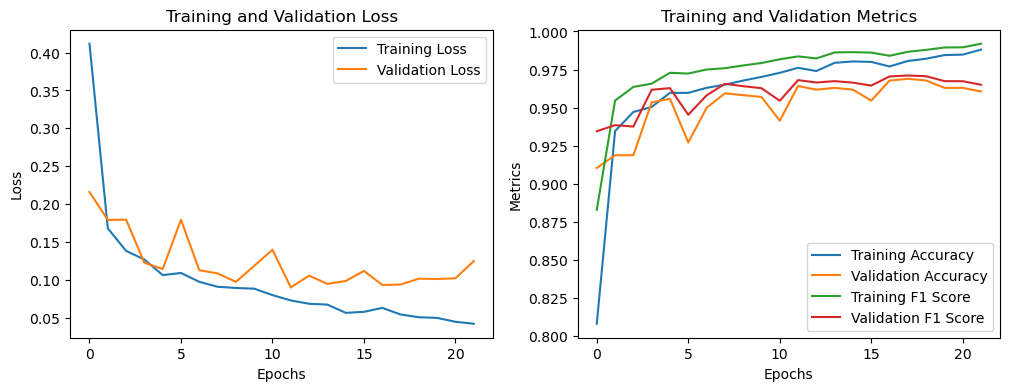

In [20]:
graphics(history)

33/33 [==============================] - 0s 2ms/step
F1-score sul set di test: 0.97


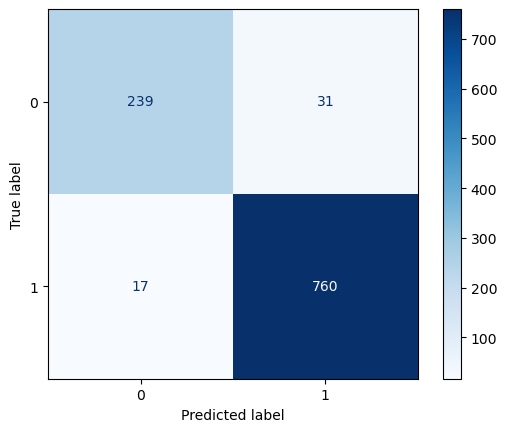

In [23]:
y_pred_prob = cnn1.predict(X_test_normalized)
y_pred = np.round(y_pred_prob).astype(int)  # Converti y_pred in int32 
# Calcola l'F1-score utilizzando la funzione f1_score modificata
test_f1 = f1_score(y_test, y_pred)
print(f"F1-score sul set di test: {test_f1:.2f}")

# Calcola la confusion matrix utilizzando y_valid e y_pred
cm = confusion_matrix(y_test, y_pred)

# Visualizza la confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Il modello, dalla curva riguardante la Validation Loss, mostra **overfitting**, vista la dimensione ridotta del training set, applichiamo **data Augmentation** per renderlo più corposo. Per immagini mediche non è raccomandato l'uso di flip orizzontali, evitiamo quindi il suo utilizzo tra le possibili variazioni.

Data Augmentation richiede che le immagini abbiano una dimensione aggiuntiva che rappresenti il canale dei colori.

In [25]:
X_train_expand = np.expand_dims(X_train_normalized, axis=-1)
X_val_expand = np.expand_dims(X_val_normalized, axis=-1)
X_test_expand = np.expand_dims(X_test_normalized, axis=-1)

### Data Augmentation

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    horizontal_flip=False,  # Non riflettere lungo l'asse x per immagini mediche
    fill_mode='nearest'
)

# Definisci il generatore di dati per il set di validazione senza data augmentation
val_datagen = ImageDataGenerator()

# Assicurati di adattare i generatori ai tuoi dati
train_generator = train_datagen.flow(X_train_expand, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val_expand, y_valid, batch_size=32)

Andiamo a vedere un paragone tra le immagini reali, e le immagini generate tramite il generatore.

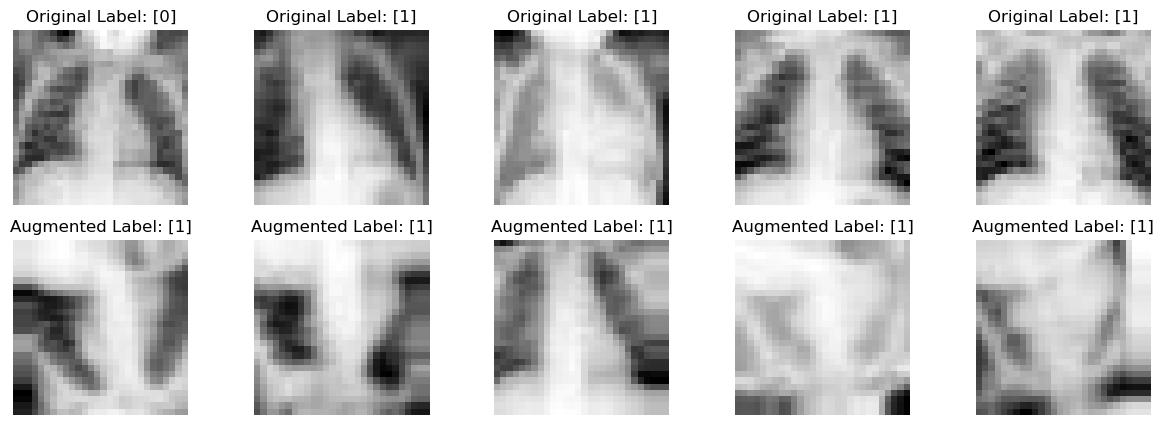

In [27]:
# Visualizza alcune immagini originali
num_images_to_display = 5
plt.figure(figsize=(15, 5))

for i in range(num_images_to_display):
    # Seleziona un'immagine casuale
    index = np.random.randint(0, len(X_train))
    original_image = X_train[index]
    original_label = y_train[index]

    # Visualizza l'immagine originale con la sua etichetta
    plt.subplot(2, num_images_to_display, i + 1)
    plt.imshow(original_image, cmap='gray')
    plt.title(f"Original Label: {original_label}")
    plt.axis('off')

# Visualizza alcune immagini generate
for i in range(num_images_to_display):
    augmented_data = next(train_generator)
    augmented_image = augmented_data[0][0]  # Ottieni l'immagine generata
    augmented_label = augmented_data[1][0]  # Ottieni l'etichetta generata

    # Visualizza l'immagine generata con la sua etichetta
    plt.subplot(2, num_images_to_display, num_images_to_display + i + 1)
    plt.imshow(augmented_image, cmap='gray')
    plt.title(f"Augmented Label: {augmented_label}")
    plt.axis('off')

plt.show()

In [38]:
cnn1_augmentation = Sequential([
    Conv2D(8, kernel_size=(3, 3), activation='relu',padding='same',input_shape=(28,28,1)),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Conv2D(16, kernel_size=(5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Flatten(),
    Dense(120, activation='relu'),
    Dense(84, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [39]:
cnn1_augmentation.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score_personalized])

# Addestramento del modello con data augmentation
history2 = cnn1_augmentation.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/50
105/105 [==============================] - 7s 56ms/step - loss: 0.4622 - accuracy: 0.7864 - f1_score_personalized: 0.8699 - val_loss: 0.2731 - val_accuracy: 0.8853 - val_f1_score_personalized: 0.9248
Epoch 2/50
105/105 [==============================] - 5s 48ms/step - loss: 0.2923 - accuracy: 0.8698 - f1_score_personalized: 0.9107 - val_loss: 0.2548 - val_accuracy: 0.8973 - val_f1_score_personalized: 0.9305
Epoch 3/50
105/105 [==============================] - 4s 38ms/step - loss: 0.2652 - accuracy: 0.8850 - f1_score_personalized: 0.9206 - val_loss: 0.2993 - val_accuracy: 0.8650 - val_f1_score_personalized: 0.8930
Epoch 4/50
105/105 [==============================] - 5s 46ms/step - loss: 0.2484 - accuracy: 0.8931 - f1_score_personalized: 0.9260 - val_loss: 0.2311 - val_accuracy: 0.9080 - val_f1_score_personalized: 0.9334
Epoch 5/50
105/105 [==============================] - 5s 43ms/step - loss: 0.2167 - accuracy: 0.9119 - f1_score_personalized: 0.9401 - val_loss: 0.1926 - va

Epoch 40/50
105/105 [==============================] - 5s 50ms/step - loss: 0.1005 - accuracy: 0.9612 - f1_score_personalized: 0.9729 - val_loss: 0.1155 - val_accuracy: 0.9522 - val_f1_score_personalized: 0.9682
Epoch 41/50
105/105 [==============================] - 5s 46ms/step - loss: 0.0964 - accuracy: 0.9624 - f1_score_personalized: 0.9741 - val_loss: 0.1325 - val_accuracy: 0.9558 - val_f1_score_personalized: 0.9710
Epoch 42/50
105/105 [==============================] - 5s 49ms/step - loss: 0.1069 - accuracy: 0.9591 - f1_score_personalized: 0.9720 - val_loss: 0.1272 - val_accuracy: 0.9474 - val_f1_score_personalized: 0.9612
Epoch 43/50
105/105 [==============================] - 5s 45ms/step - loss: 0.0915 - accuracy: 0.9662 - f1_score_personalized: 0.9768 - val_loss: 0.1022 - val_accuracy: 0.9630 - val_f1_score_personalized: 0.9758
Epoch 44/50
105/105 [==============================] - 4s 35ms/step - loss: 0.1052 - accuracy: 0.9606 - f1_score_personalized: 0.9730 - val_loss: 0.1498

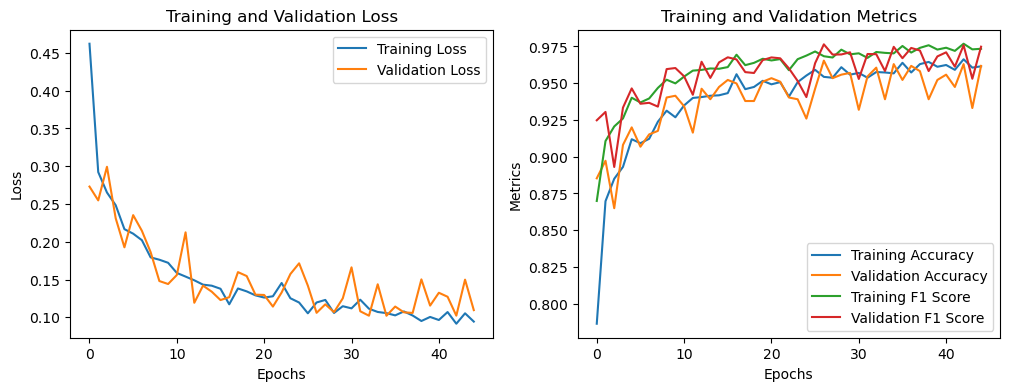

In [40]:
graphics(history2)

33/33 [==============================] - 0s 3ms/step
F1-score sul set di test: 0.97


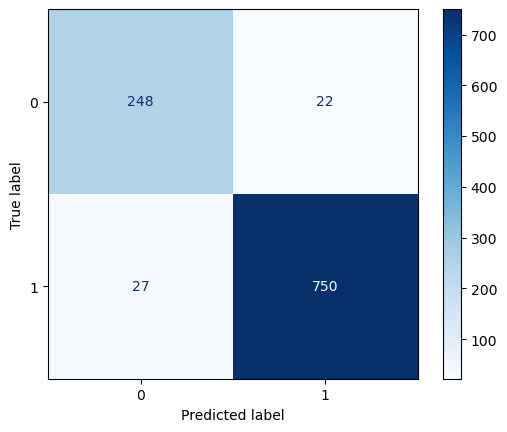

In [41]:
y_pred_prob = cnn1_augmentation.predict(X_test_normalized)
y_pred = np.round(y_pred_prob).astype(int)  # Converti y_pred in int32 
# Calcola l'F1-score utilizzando la funzione f1_score modificata
test_f1 = f1_score(y_test, y_pred)
print(f"F1-score sul set di test: {test_f1:.2f}")

# Calcola la confusion matrix utilizzando y_valid e y_pred
cm = confusion_matrix(y_test, y_pred)

# Visualizza la confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Proviamo ora un modello più performante, scegliendo un modello VGG-Like

In [42]:
cnn2 = Sequential([
    Conv2D(8, kernel_size=(3, 3), activation='relu',padding='same',input_shape=(28,28,1)),
    Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(6, 6),strides=2),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2),strides=2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [43]:
# Compilazione del modello
cnn2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score_personalized])

cnn2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 28, 28, 8)         80        
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 16)        1168      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 12, 12, 16)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 10, 10, 32)        4640      
                                                                 
 conv2d_13 (Conv2D)          (None, 8, 8, 32)          9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                  

In [44]:
# Addestramento del modello
history3 = cnn2.fit( train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stopping])

Epoch 1/100
105/105 [==============================] - 8s 60ms/step - loss: 0.4183 - accuracy: 0.8056 - f1_score_personalized: 0.8752 - val_loss: 0.2734 - val_accuracy: 0.8734 - val_f1_score_personalized: 0.9116
Epoch 2/100
105/105 [==============================] - 4s 40ms/step - loss: 0.2514 - accuracy: 0.8883 - f1_score_personalized: 0.9230 - val_loss: 0.3188 - val_accuracy: 0.8339 - val_f1_score_personalized: 0.8717
Epoch 3/100
105/105 [==============================] - 6s 59ms/step - loss: 0.2201 - accuracy: 0.9077 - f1_score_personalized: 0.9364 - val_loss: 0.2314 - val_accuracy: 0.8961 - val_f1_score_personalized: 0.9261
Epoch 4/100
105/105 [==============================] - 7s 63ms/step - loss: 0.2062 - accuracy: 0.9161 - f1_score_personalized: 0.9424 - val_loss: 0.2438 - val_accuracy: 0.8853 - val_f1_score_personalized: 0.9124
Epoch 5/100
105/105 [==============================] - 6s 61ms/step - loss: 0.1775 - accuracy: 0.9271 - f1_score_personalized: 0.9496 - val_loss: 0.3059

105/105 [==============================] - 6s 59ms/step - loss: 0.0875 - accuracy: 0.9657 - f1_score_personalized: 0.9765 - val_loss: 0.1454 - val_accuracy: 0.9450 - val_f1_score_personalized: 0.9617
Epoch 40/100
105/105 [==============================] - 6s 62ms/step - loss: 0.0936 - accuracy: 0.9671 - f1_score_personalized: 0.9770 - val_loss: 0.1121 - val_accuracy: 0.9582 - val_f1_score_personalized: 0.9717
Epoch 41/100
105/105 [==============================] - 7s 65ms/step - loss: 0.0965 - accuracy: 0.9624 - f1_score_personalized: 0.9737 - val_loss: 0.1800 - val_accuracy: 0.9331 - val_f1_score_personalized: 0.9527
Epoch 42/100
105/105 [==============================] - 6s 60ms/step - loss: 0.0941 - accuracy: 0.9662 - f1_score_personalized: 0.9769 - val_loss: 0.1181 - val_accuracy: 0.9594 - val_f1_score_personalized: 0.9719
Epoch 43/100
105/105 [==============================] - 6s 53ms/step - loss: 0.0962 - accuracy: 0.9642 - f1_score_personalized: 0.9757 - val_loss: 0.0940 - val_a

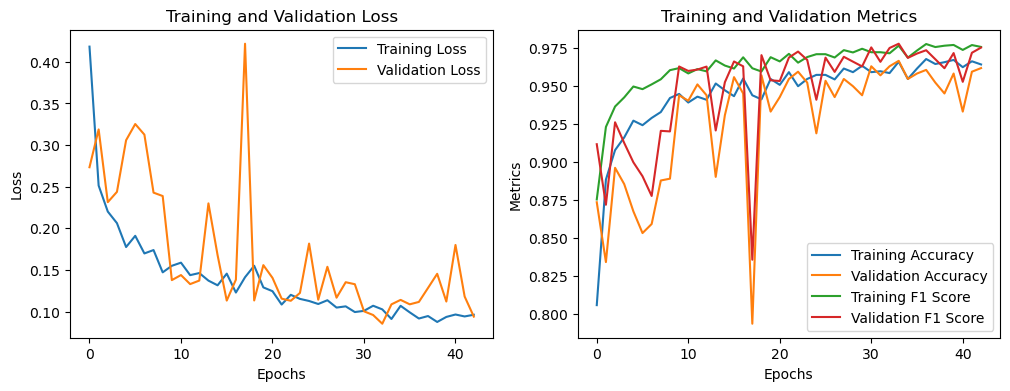

In [45]:
graphics(history3)

Aggiungiamo alcuni strumenti per migliorare la convergenza:
* He Normalization: metodo di inizializzazione dei pesi delle reti neurali, che sembra funzionare molto bene con ReLU
* L2: tecnica di regolarizzazione che va ad aggiungere un termine alla funzione di perdita che penalizza i pesi grandi, forzandoli a rimanere piccoli durante l'addestramento
* ReduceLROnPlateau: callback di Keras che riduce il tasso di apprendimento (learning rate) quando una metrica monitorata smette di migliorare. È utile per accelerare il processo di addestramento e migliorare la convergenza del modello.
* BatchNormalization: tecnica che normalizza i valori di attivazione tra i layer di una rete neurale, rendendo l'addestramento più veloce e stabile. Aiuta anche a prevenire l'overfitting.

In [46]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_normal

In [47]:
cnn2_tune = Sequential([
    Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28, 28, 1), kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    BatchNormalization(),
    Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    BatchNormalization(),
    Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer=he_normal()),
    BatchNormalization(),
    Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer=he_normal()),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    BatchNormalization(),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    Dense(1, activation='sigmoid')
])

In [50]:
# Compilazione del modello
cnn2_tune.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score_personalized])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

cnn2_tune.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 28, 28, 8)         80        
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 8)        32        
 ormalization)                                                   
                                                                 
 conv2d_15 (Conv2D)          (None, 28, 28, 16)        1168      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 16)       64        
 hNormalization)                                                 
                                                      

In [51]:
history4 = cnn2_tune.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
105/105 [==============================] - 7s 47ms/step - loss: 1.2054 - accuracy: 0.9038 - f1_score_personalized: 0.9331 - val_loss: 2.4723 - val_accuracy: 0.7419 - val_f1_score_personalized: 0.8514 - lr: 0.0010
Epoch 2/100
105/105 [==============================] - 5s 46ms/step - loss: 0.8387 - accuracy: 0.9421 - f1_score_personalized: 0.9610 - val_loss: 2.1620 - val_accuracy: 0.7419 - val_f1_score_personalized: 0.8479 - lr: 0.0010
Epoch 3/100
105/105 [==============================] - 5s 48ms/step - loss: 0.6611 - accuracy: 0.9450 - f1_score_personalized: 0.9613 - val_loss: 0.9910 - val_accuracy: 0.8124 - val_f1_score_personalized: 0.8859 - lr: 0.0010
Epoch 4/100
105/105 [==============================] - 5s 43ms/step - loss: 0.5198 - accuracy: 0.9561 - f1_score_personalized: 0.9697 - val_loss: 0.5055 - val_accuracy: 0.9415 - val_f1_score_personalized: 0.9592 - lr: 0.0010
Epoch 5/100
105/105 [==============================] - 4s 42ms/step - loss: 0.4351 - accuracy: 0.951

105/105 [==============================] - 5s 48ms/step - loss: 0.0809 - accuracy: 0.9833 - f1_score_personalized: 0.9886 - val_loss: 0.1163 - val_accuracy: 0.9701 - val_f1_score_personalized: 0.9798 - lr: 1.0000e-04
Epoch 38/100
105/105 [==============================] - 5s 45ms/step - loss: 0.0812 - accuracy: 0.9854 - f1_score_personalized: 0.9900 - val_loss: 0.1162 - val_accuracy: 0.9701 - val_f1_score_personalized: 0.9804 - lr: 1.0000e-04
Epoch 39/100
105/105 [==============================] - 5s 47ms/step - loss: 0.0821 - accuracy: 0.9851 - f1_score_personalized: 0.9897 - val_loss: 0.1104 - val_accuracy: 0.9737 - val_f1_score_personalized: 0.9824 - lr: 1.0000e-04
Epoch 40/100
105/105 [==============================] - 5s 46ms/step - loss: 0.0794 - accuracy: 0.9869 - f1_score_personalized: 0.9909 - val_loss: 0.1208 - val_accuracy: 0.9665 - val_f1_score_personalized: 0.9771 - lr: 1.0000e-04
Epoch 41/100
105/105 [==============================] - 5s 46ms/step - loss: 0.0747 - accurac

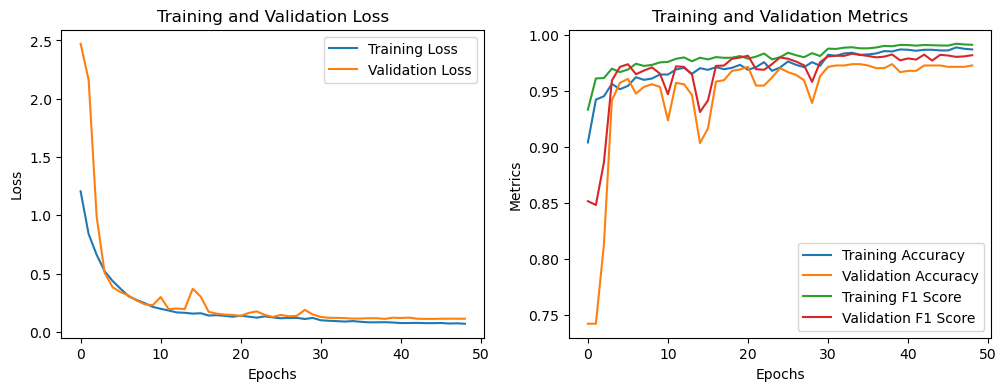

In [52]:
graphics(history4)

In [ ]:
test_loss, test_accuracy, test_f1 = cnn2_tune.evaluate(X_test_expand, y_test, batch_size=64)

print(f"Loss sul set di test: {test_loss}")
print(f"Accuracy sul set di test: {test_accuracy}")
print(f"F1 Score sul set di test: {test_f1}")

17/17 [==============================] - 0s 7ms/step - loss: 0.1569 - accuracy: 0.9599 - f1_score: 0.9729
Loss sul set di test: 0.15693019330501556
Accuracy sul set di test: 0.9598853588104248
F1 Score sul set di test: 0.97288578748703


33/33 [==============================] - 0s 3ms/step


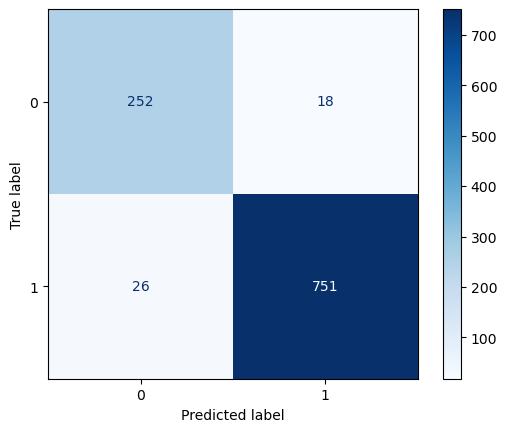

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_prob = cnn1.predict(X_test_expand)
y_pred = np.round(y_pred_prob).astype(int)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
from tensorflow.keras.layers import Dropout

In [ ]:
cnn3 = Sequential([
    Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28, 28, 1), kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),
    BatchNormalization(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001), kernel_initializer=he_normal()),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [ ]:
# Compilazione del modello
cnn3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_score])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

cnn3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 28, 28, 8)         80        
                                                                 
 batch_normalization_29 (Bat  (None, 28, 28, 8)        32        
 chNormalization)                                                
                                                                 
 dropout_7 (Dropout)         (None, 28, 28, 8)         0         
                                                                 
 conv2d_52 (Conv2D)          (None, 28, 28, 16)        1168      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 14, 14, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_30 (Bat  (None, 14, 14, 16)     

In [ ]:
history5 = cnn3.fit(
    train_generator,
    steps_per_epoch=len(X_train_normalized) // 32,
    epochs=120,
    validation_data=val_generator,
    validation_steps=len(X_val_normalized) // 32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/120
104/104 [==============================] - 8s 56ms/step - loss: 1.7003 - accuracy: 0.8589 - f1_score: 0.9034 - val_loss: 4.0338 - val_accuracy: 0.7404 - val_f1_score: 0.8487 - lr: 0.0010
Epoch 2/120
104/104 [==============================] - 5s 52ms/step - loss: 1.3983 - accuracy: 0.8896 - f1_score: 0.9244 - val_loss: 5.4174 - val_accuracy: 0.7428 - val_f1_score: 0.8490 - lr: 0.0010
Epoch 3/120
104/104 [==============================] - 11s 102ms/step - loss: 1.1975 - accuracy: 0.9047 - f1_score: 0.9344 - val_loss: 4.6538 - val_accuracy: 0.7440 - val_f1_score: 0.8503 - lr: 0.0010
Epoch 4/120
104/104 [==============================] - 8s 74ms/step - loss: 1.0386 - accuracy: 0.9279 - f1_score: 0.9513 - val_loss: 2.5904 - val_accuracy: 0.7452 - val_f1_score: 0.8519 - lr: 0.0010
Epoch 5/120
104/104 [==============================] - 7s 62ms/step - loss: 0.9139 - accuracy: 0.9340 - f1_score: 0.9547 - val_loss: 1.4423 - val_accuracy: 0.7969 - val_f1_score: 0.8777 - lr: 0.0010
Epo

Epoch 42/120
104/104 [==============================] - 4s 40ms/step - loss: 0.2034 - accuracy: 0.9677 - f1_score: 0.9781 - val_loss: 0.2421 - val_accuracy: 0.9531 - val_f1_score: 0.9690 - lr: 0.0010
Epoch 43/120
104/104 [==============================] - 7s 64ms/step - loss: 0.2193 - accuracy: 0.9611 - f1_score: 0.9733 - val_loss: 0.2199 - val_accuracy: 0.9627 - val_f1_score: 0.9740 - lr: 0.0010
Epoch 44/120
104/104 [==============================] - 5s 52ms/step - loss: 0.2014 - accuracy: 0.9623 - f1_score: 0.9745 - val_loss: 0.2329 - val_accuracy: 0.9555 - val_f1_score: 0.9688 - lr: 0.0010
Epoch 45/120
104/104 [==============================] - 6s 55ms/step - loss: 0.2027 - accuracy: 0.9662 - f1_score: 0.9770 - val_loss: 0.1963 - val_accuracy: 0.9639 - val_f1_score: 0.9745 - lr: 0.0010
Epoch 46/120
104/104 [==============================] - 5s 47ms/step - loss: 0.2012 - accuracy: 0.9626 - f1_score: 0.9743 - val_loss: 0.2132 - val_accuracy: 0.9471 - val_f1_score: 0.9631 - lr: 0.0010


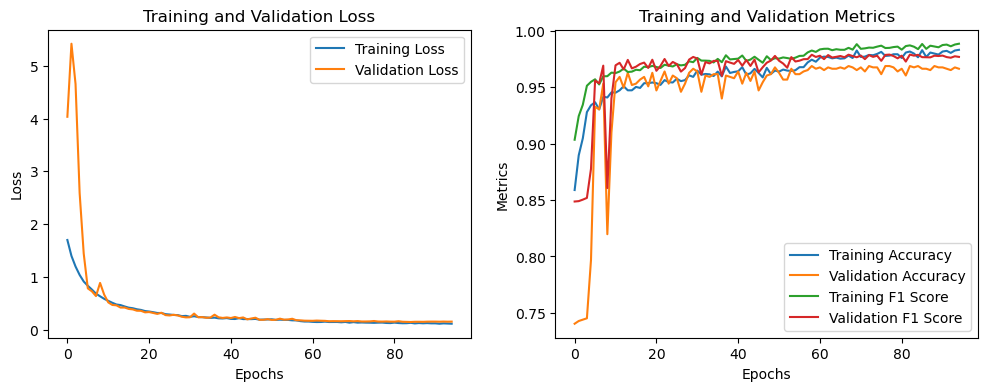

In [ ]:
graphics(history5)

In [ ]:
test_loss, test_accuracy, test_f1 = cnn3.evaluate(X_test_expand, y_test, batch_size=64)

print(f"Loss sul set di test: {test_loss}")
print(f"Accuracy sul set di test: {test_accuracy}")
print(f"F1 Score sul set di test: {test_f1}")

17/17 [==============================] - 0s 11ms/step - loss: 0.1594 - accuracy: 0.9704 - f1_score: 0.9797
Loss sul set di test: 0.15941400825977325
Accuracy sul set di test: 0.970391571521759
F1 Score sul set di test: 0.979720413684845
